# **Data Preparation**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import itertools

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [2]:
data = pd.read_csv('BankChurners.csv')
data.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [3]:
# Drop uninformative columns
data = data.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)

In [4]:
# Check types of data and perpare for later modification
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [5]:
# Check null values
data.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [6]:
# Check for duplicates
data.duplicated().sum()

0

In [7]:
# Check distrubution of target variable (Attrition_Flag)
target_data = data['Attrition_Flag'].value_counts().reset_index()
target_data.columns = ['Customer status','Count']
target_data['Percentage'] = target_data['Count'].apply(lambda x: x/target_data['Count'].sum()*100)
target_data

,Customer status,Count,Percentage
0,Existing Customer,8500,83.934038
1,Attrited Customer,1627,16.065962


The distribution above indicates the dataset is highly unbalanced since there are only 16.07 are attrited customers, meaning treatment need to be done before modeling.

We also want to examine and find outliers in the other variables


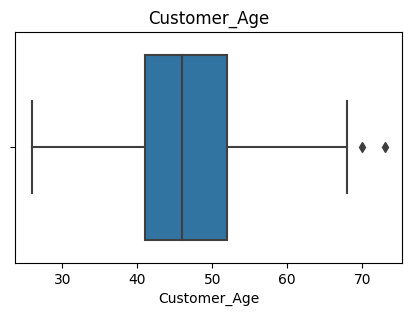

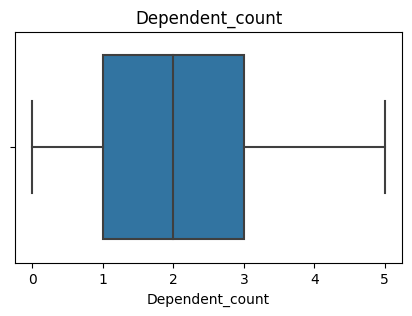

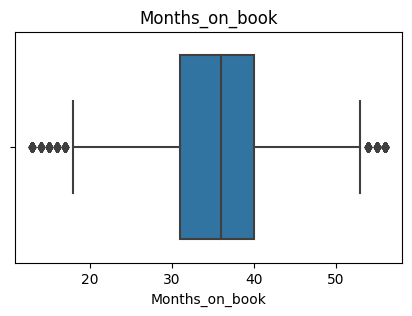

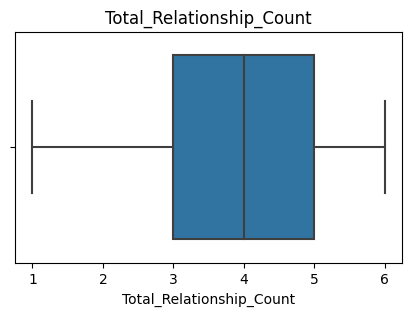

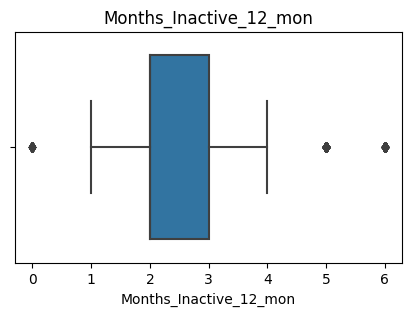

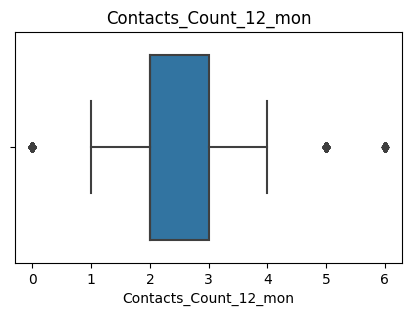

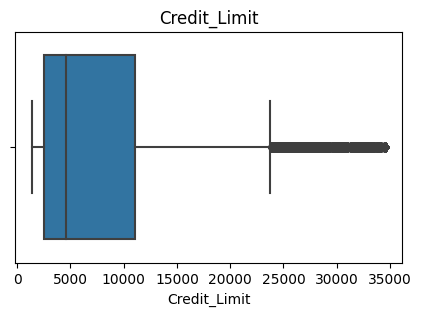

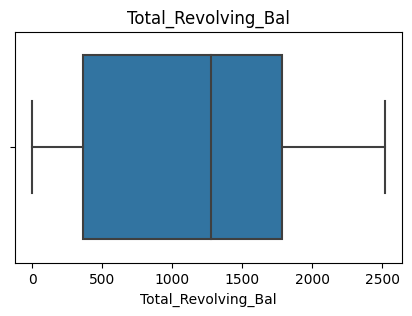

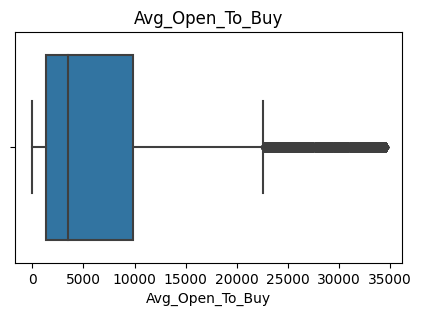

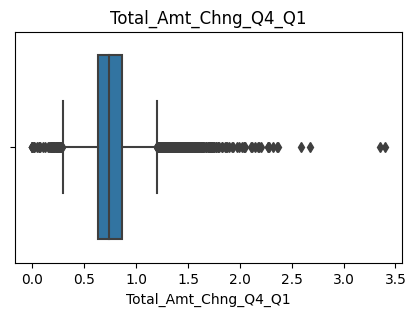

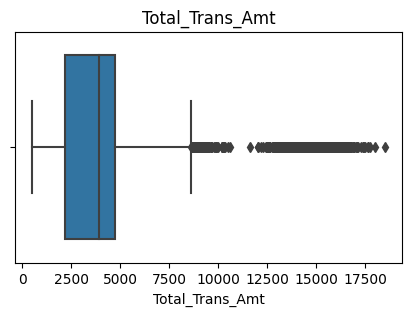

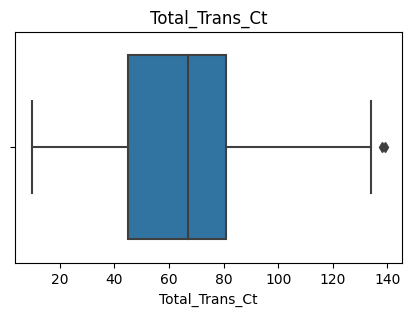

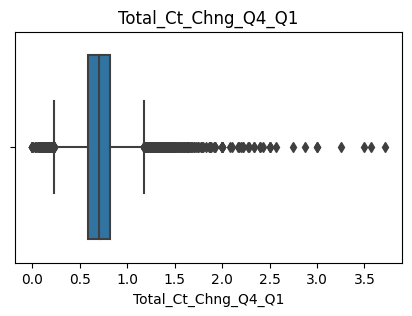

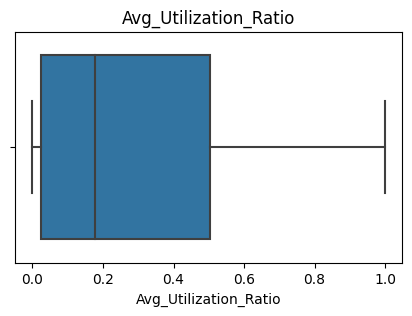

In [8]:
# Define a function to visualize and store outliers
def visualize_and_store_outliers(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    # Store outliers
    outliers_indices = outliers.index.tolist()

    # Visualize outliers
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[column])
    plt.title(f'{column}')
    plt.show()

    return outliers_indices

# Columns to check for outliers
columns_to_check = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                    'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
                    'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy',
                    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
                    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# Dictionary to store outliers for each column
outliers_dict = {}

# Apply the visualization and storage function to each column
for column in columns_to_check:
    outliers_dict[column] = visualize_and_store_outliers(data, column)

Based on the above boxplots, variables with many outliers and a wide range are: `Credit_Limit`,`Avg_Open_To_Buy`, and `Total_Trans_Amt`. We want to treat these column with outliers through a scaler




In [9]:
columns_to_scale = ['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt']

# Initialize scaler and transform data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(data[columns_to_scale])

# Create a new DataFrame with the scaled values
scaler_df = pd.DataFrame(df_scaled, columns=columns_to_scale)
# scaler_df

In [10]:
# Drop the original columns with outlier and add the scaled one into it
data.drop(['Credit_Limit','Avg_Open_To_Buy','Total_Trans_Amt','Total_Revolving_Bal'],axis=1,inplace=True)
data = pd.concat([data,scaler_df],axis=1)
# data

Convert categorical variables through one-hot encoding using labelencoder

In [11]:
categorical_columns = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# Create a copy of the data
df_encoded = data.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Store labels for different category
label_mappings = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    label_mappings[column] = {index: label for index, label in enumerate(label_encoder.classes_)}

df_encoded

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Credit_Limit,Avg_Open_To_Buy,Total_Trans_Amt
0,Existing Customer,45,1,3,3,1,2,0,39,5,1,3,1.335,42,1.625,0.061,0.340190,0.345116,0.035273
1,Existing Customer,49,0,5,2,2,4,0,44,6,1,2,1.541,33,3.714,0.105,0.206112,0.214093,0.043452
2,Existing Customer,51,1,3,2,1,3,0,36,4,1,0,2.594,20,2.333,0.000,0.059850,0.098948,0.076611
3,Existing Customer,40,0,4,3,3,4,0,34,3,4,1,1.405,20,2.333,0.760,0.056676,0.022977,0.036775
4,Existing Customer,40,1,3,5,1,2,0,21,5,1,0,2.175,28,2.500,0.000,0.099091,0.136557,0.017025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,1,2,2,2,1,0,40,3,2,3,0.703,117,0.857,0.462,0.077536,0.062266,0.832647
10123,Attrited Customer,41,1,2,6,0,1,0,25,4,2,3,0.804,69,0.683,0.511,0.085819,0.060499,0.459219
10124,Attrited Customer,44,0,1,3,1,4,0,36,5,3,4,0.819,60,0.818,0.000,0.120042,0.156637,0.544175
10125,Attrited Customer,30,1,2,2,3,1,0,36,4,3,3,0.535,62,0.722,0.000,0.116172,0.152928,0.438689


In [12]:
# Ensure the columns for df_encoded is the same as the original data
df_encoded.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Credit_Limit',
       'Avg_Open_To_Buy', 'Total_Trans_Amt'],
      dtype='object')

In [13]:
# Obtain a dict of labels for the categorical variables
label_mappings

{'Gender': {0: 'F', 1: 'M'},
 'Education_Level': {0: 'College',
  1: 'Doctorate',
  2: 'Graduate',
  3: 'High School',
  4: 'Post-Graduate',
  5: 'Uneducated',
  6: 'Unknown'},
 'Marital_Status': {0: 'Divorced', 1: 'Married', 2: 'Single', 3: 'Unknown'},
 'Income_Category': {0: '$120K +',
  1: '$40K - $60K',
  2: '$60K - $80K',
  3: '$80K - $120K',
  4: 'Less than $40K',
  5: 'Unknown'},
 'Card_Category': {0: 'Blue', 1: 'Gold', 2: 'Platinum', 3: 'Silver'}}

Check the corrlation between all variables to the targeted variable through heatmap

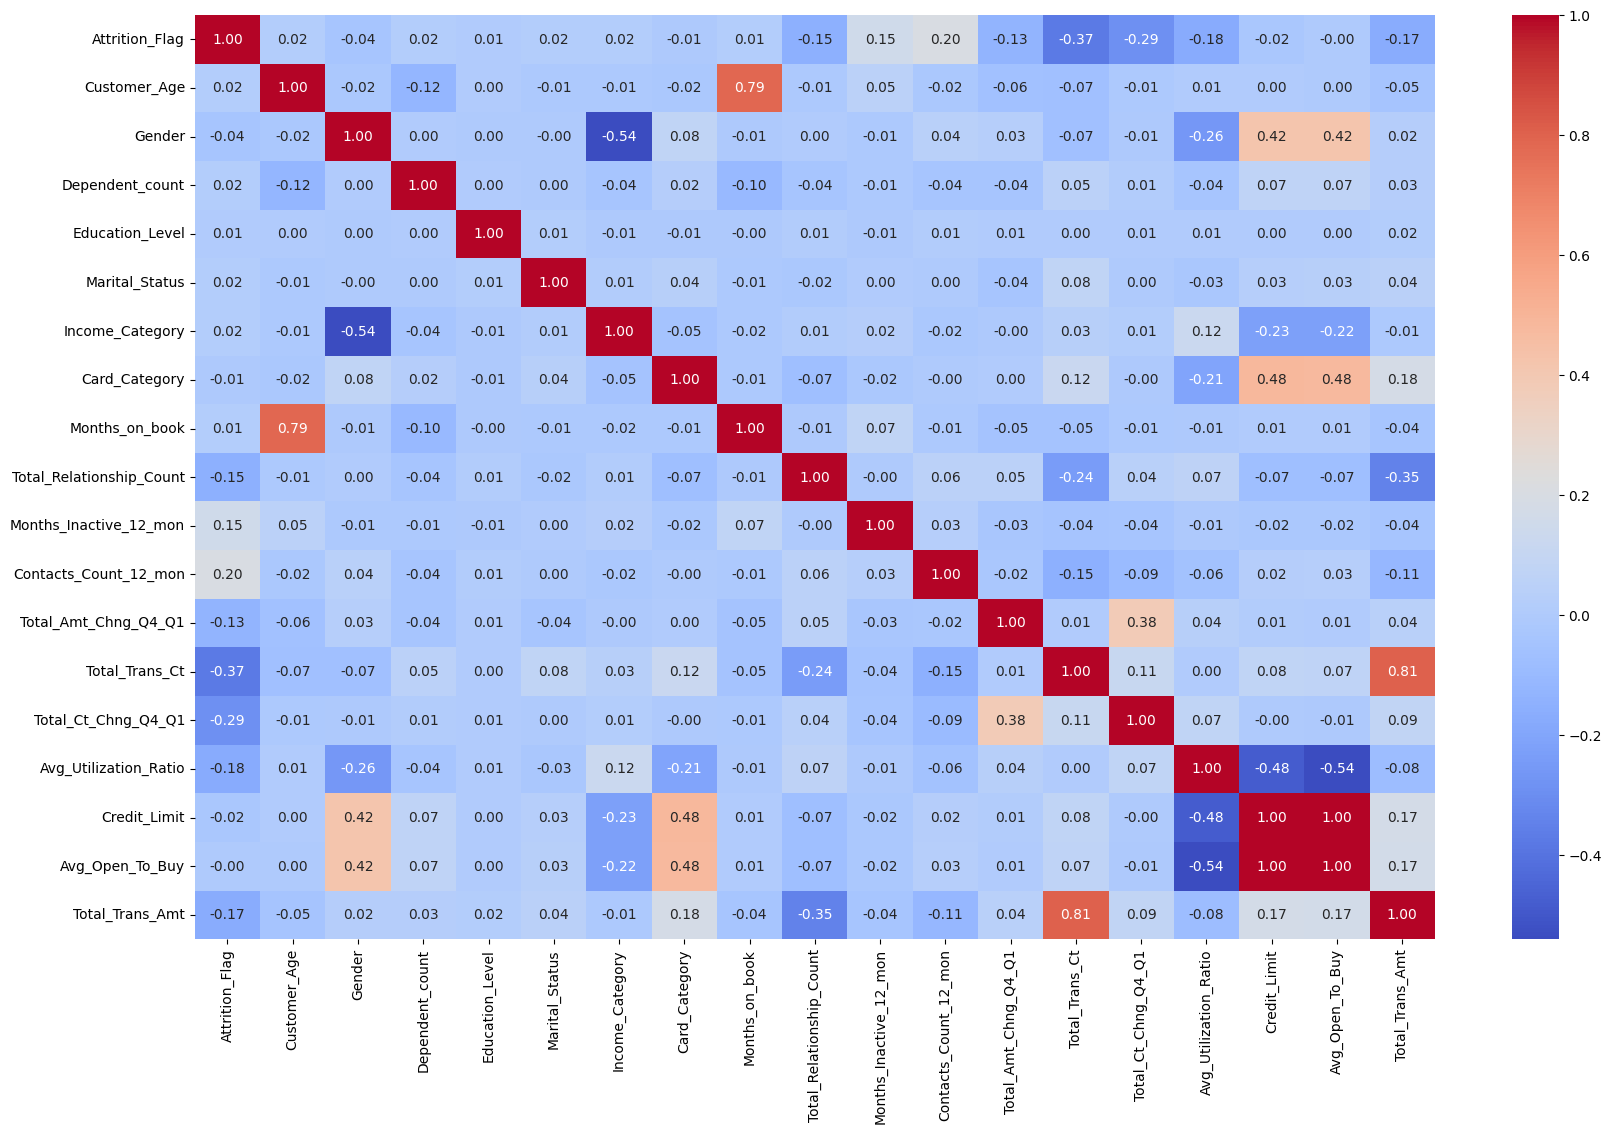

In [14]:
df_encoded['Attrition_Flag'] = df_encoded['Attrition_Flag'] .replace({'Attrited Customer':1,'Existing Customer':0})
# df_encoded

corr_matrix = df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 12))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

# Show the plot
plt.show()

Since there are so few clients that churn within the dataset, we want to amplify the potential relationship by upsampling the data through SMOTE

In [15]:
oversample = SMOTE()
X, y = oversample.fit_resample(df_encoded[df_encoded.columns[1:]], df_encoded[df_encoded.columns[0]])
upsampled_df = X.assign(Attrition_Flag = y)
# upsampled_df

In [16]:
target_data = upsampled_df['Attrition_Flag'].value_counts().reset_index()
target_data.columns = ['Customer status','Count']
target_data['Percentage'] = target_data['Count'].apply(lambda x: x/target_data['Count'].sum()*100)
target_data

,Customer status,Count,Percentage
0,0,8500,50.0
1,1,8500,50.0


Check the corrlation between all variables to the targeted variable after SMOTE through heatmap

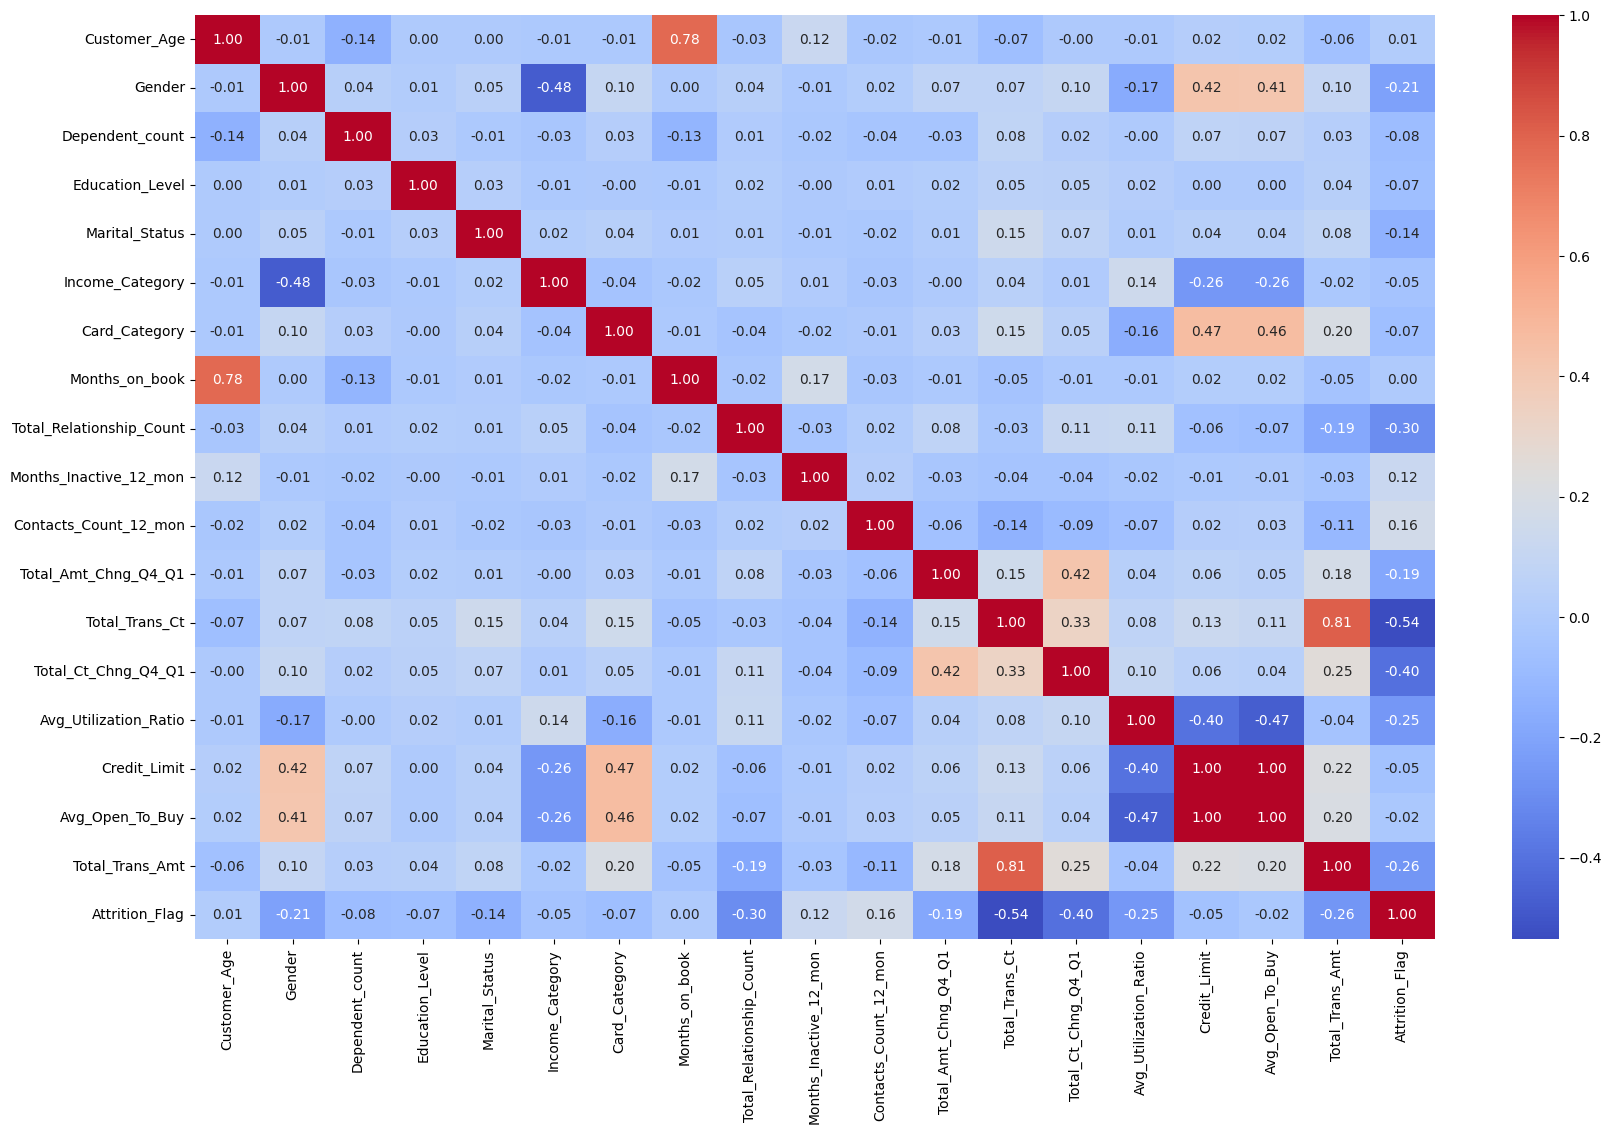

In [17]:
corr_matrix = upsampled_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 12))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

# Show the plot
plt.show()

In [18]:
# upsampled_df.info()

# Modeling

Create a 70-30 train test data split and create train and valid loader based on the splited data

In [19]:
X = upsampled_df.drop('Attrition_Flag', axis=1).values  # Convert to numpy
y = upsampled_df['Attrition_Flag'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11900, 18)
(5100, 18)
(11900,)
(5100,)


In [21]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create Tensor datasets and data loaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([11900, 18])
torch.Size([5100, 18])
torch.Size([11900])
torch.Size([5100])


Define base MLP model

In [23]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [24]:
# Initialize the MLP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=X.shape[1])
model = model.to(device)
print(device)

epoch_num = 35
learning_rate = 0.001
weight_decay = 1e-3

cuda:0


Define a function to train and validate model that allows inputs of various hyperparameters and detects early stopping. `patience` is a hyperparameter that determines the number of epochs to wait before triggering early stop when the validation loss is not improving

In [25]:
def train_and_evaluate(model, train_loader, valid_loader, num_epochs = 20, learning_rate=0.001, weight_decay=0.0, patience = 5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    # Define loss function
    criterion = nn.BCELoss()
    # Define optimizer with hyperparameters
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early stopping initialization
    the_last_loss = float('inf')
    the_last_accuracy = 0
    epochs_no_improve = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training loop
        model.train()  # Set the model to training mode
        total_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float().squeeze()
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

        avg_train_loss = total_train_loss / total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)

                total_val_loss += loss.item() * inputs.size(0)
                predicted = (outputs >= 0.5).float().squeeze()
                correct_val_predictions += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        avg_val_loss = total_val_loss / total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Early stopping and model checkpointing
        if avg_val_loss < the_last_loss or val_accuracy > the_last_accuracy:
            epochs_no_improve = 0
            the_last_loss = avg_val_loss
            the_last_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')  # Save the model checkpoint
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs!')
                break

    print(f'The best model was found at epoch {best_epoch + 1} with Validation Loss: {the_last_loss:.4f}, Validation Accuracy: {the_last_accuracy:.4f}.')
    return train_losses, train_accuracies, val_losses, val_accuracies, best_epoch


In [26]:
# Train base MLP model
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model, train_loader, valid_loader, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)

Epoch 1/35, Training Loss: 0.4253, Training Accuracy: 0.8236, Validation Loss: 0.2890, Validation Accuracy: 0.8806
Epoch 2/35, Training Loss: 0.2525, Training Accuracy: 0.8955, Validation Loss: 0.2244, Validation Accuracy: 0.9143
Epoch 3/35, Training Loss: 0.2118, Training Accuracy: 0.9140, Validation Loss: 0.2114, Validation Accuracy: 0.9171
Epoch 4/35, Training Loss: 0.1983, Training Accuracy: 0.9182, Validation Loss: 0.2030, Validation Accuracy: 0.9218
Epoch 5/35, Training Loss: 0.1909, Training Accuracy: 0.9217, Validation Loss: 0.1930, Validation Accuracy: 0.9247
Epoch 6/35, Training Loss: 0.1849, Training Accuracy: 0.9254, Validation Loss: 0.1877, Validation Accuracy: 0.9253
Epoch 7/35, Training Loss: 0.1795, Training Accuracy: 0.9278, Validation Loss: 0.1847, Validation Accuracy: 0.9286
Epoch 8/35, Training Loss: 0.1748, Training Accuracy: 0.9310, Validation Loss: 0.1932, Validation Accuracy: 0.9208
Epoch 9/35, Training Loss: 0.1724, Training Accuracy: 0.9323, Validation Loss: 0

Define a function to show change in loss and accuracy through out training

In [27]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)  # This will be the actual number of epochs trained
    plt.figure(figsize=(14, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


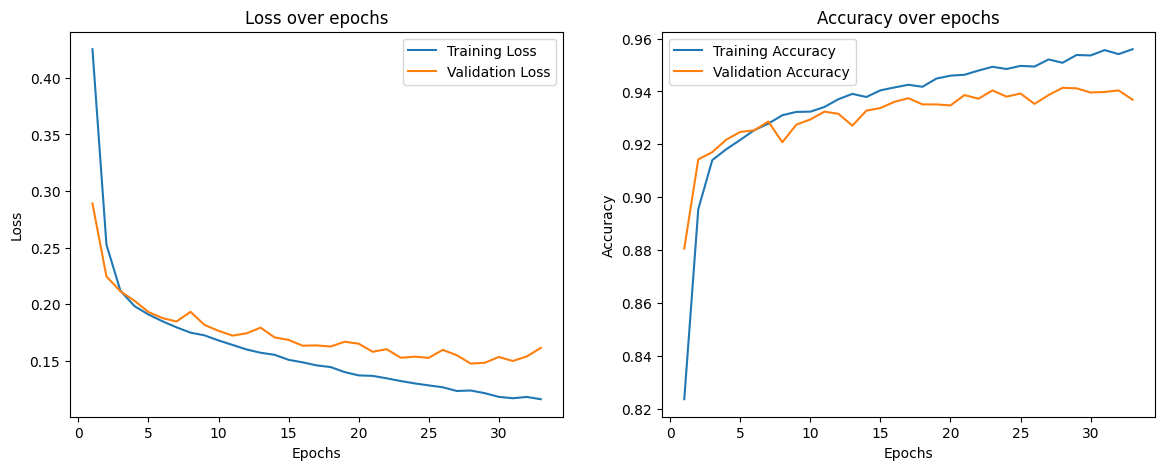

In [28]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

**Model optimazation**

1. Increase the number of neurons in each hidden layer

In [56]:
class MLP_opt1(nn.Module):
    def __init__(self, input_size):
        super(MLP_opt1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [57]:
model_opt1 = MLP_opt1(input_size=X.shape[1])

In [58]:
model_opt1

MLP_opt1(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [59]:
model_opt1.to(device)
print(device)

cuda:0


Epoch 1/35, Training Loss: 0.3172, Training Accuracy: 0.8655, Validation Loss: 0.2242, Validation Accuracy: 0.9067
Epoch 2/35, Training Loss: 0.2089, Training Accuracy: 0.9157, Validation Loss: 0.2099, Validation Accuracy: 0.9145
Epoch 3/35, Training Loss: 0.1888, Training Accuracy: 0.9235, Validation Loss: 0.1880, Validation Accuracy: 0.9259
Epoch 4/35, Training Loss: 0.1775, Training Accuracy: 0.9278, Validation Loss: 0.1889, Validation Accuracy: 0.9251
Epoch 5/35, Training Loss: 0.1675, Training Accuracy: 0.9332, Validation Loss: 0.1826, Validation Accuracy: 0.9253
Epoch 6/35, Training Loss: 0.1625, Training Accuracy: 0.9334, Validation Loss: 0.1764, Validation Accuracy: 0.9286
Epoch 7/35, Training Loss: 0.1511, Training Accuracy: 0.9391, Validation Loss: 0.1604, Validation Accuracy: 0.9349
Epoch 8/35, Training Loss: 0.1438, Training Accuracy: 0.9431, Validation Loss: 0.1600, Validation Accuracy: 0.9339
Epoch 9/35, Training Loss: 0.1396, Training Accuracy: 0.9448, Validation Loss: 0

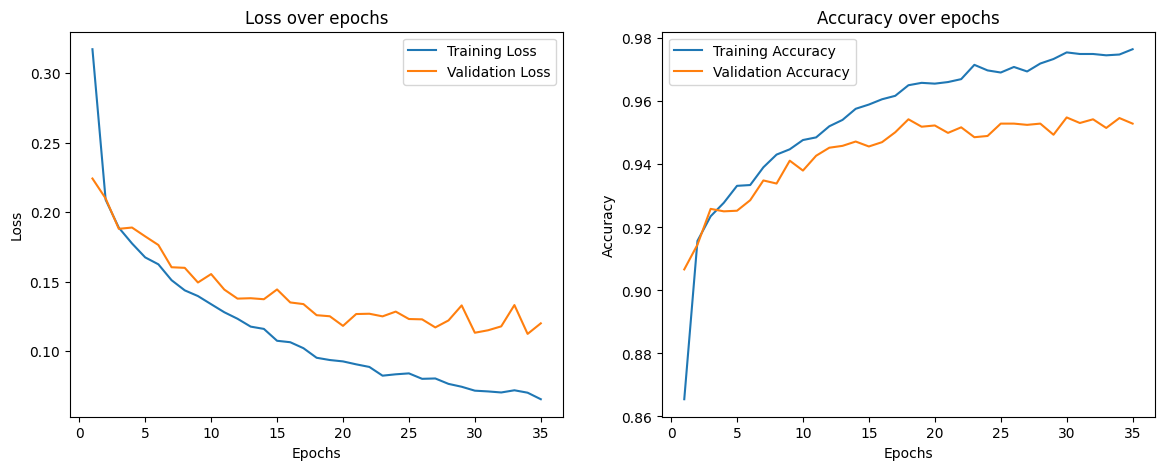

In [60]:
epoch_num = 35
learning_rate = 0.001
weight_decay = 1e-3
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model_opt1, train_loader, valid_loader, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


2. Increase the number of hidden layers

cuda:0
Epoch 1/35, Training Loss: 0.2880, Training Accuracy: 0.8783, Validation Loss: 0.2050, Validation Accuracy: 0.9178
Epoch 2/35, Training Loss: 0.2011, Training Accuracy: 0.9203, Validation Loss: 0.1835, Validation Accuracy: 0.9247
Epoch 3/35, Training Loss: 0.1772, Training Accuracy: 0.9307, Validation Loss: 0.1779, Validation Accuracy: 0.9280
Epoch 4/35, Training Loss: 0.1619, Training Accuracy: 0.9331, Validation Loss: 0.2041, Validation Accuracy: 0.9141
Epoch 5/35, Training Loss: 0.1468, Training Accuracy: 0.9411, Validation Loss: 0.1551, Validation Accuracy: 0.9376
Epoch 6/35, Training Loss: 0.1310, Training Accuracy: 0.9459, Validation Loss: 0.1571, Validation Accuracy: 0.9412
Epoch 7/35, Training Loss: 0.1245, Training Accuracy: 0.9497, Validation Loss: 0.1520, Validation Accuracy: 0.9416
Epoch 8/35, Training Loss: 0.1173, Training Accuracy: 0.9530, Validation Loss: 0.1313, Validation Accuracy: 0.9492
Epoch 9/35, Training Loss: 0.1037, Training Accuracy: 0.9592, Validation 

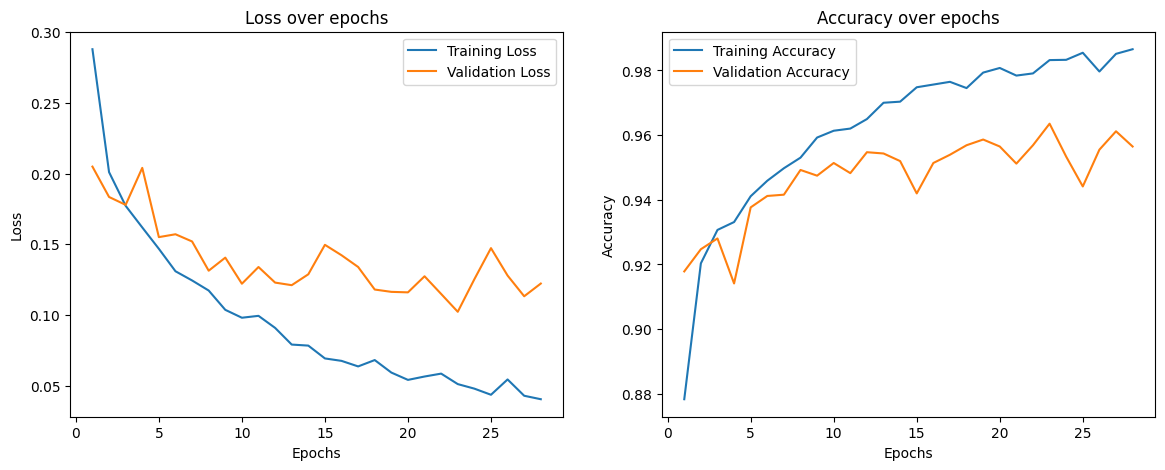

In [63]:
class MLP_opt2(nn.Module):
    def __init__(self, input_size):
        super(MLP_opt2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_opt2 = MLP_opt2(input_size=X.shape[1])
model_opt2.to(device)
print(device)

epoch_num = 35
learning_rate = 0.001
weight_decay = 1e-3
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model_opt2, train_loader, valid_loader, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)



3. Add additional dropout layers

cuda:0
Epoch 1/50, Training Loss: 0.3115, Training Accuracy: 0.8676, Validation Loss: 0.2119, Validation Accuracy: 0.9137
Epoch 2/50, Training Loss: 0.2211, Training Accuracy: 0.9084, Validation Loss: 0.1897, Validation Accuracy: 0.9275
Epoch 3/50, Training Loss: 0.2025, Training Accuracy: 0.9198, Validation Loss: 0.1908, Validation Accuracy: 0.9253
Epoch 4/50, Training Loss: 0.1848, Training Accuracy: 0.9248, Validation Loss: 0.1642, Validation Accuracy: 0.9355
Epoch 5/50, Training Loss: 0.1759, Training Accuracy: 0.9299, Validation Loss: 0.1786, Validation Accuracy: 0.9275
Epoch 6/50, Training Loss: 0.1676, Training Accuracy: 0.9316, Validation Loss: 0.1639, Validation Accuracy: 0.9329
Epoch 7/50, Training Loss: 0.1603, Training Accuracy: 0.9381, Validation Loss: 0.1487, Validation Accuracy: 0.9429
Epoch 8/50, Training Loss: 0.1543, Training Accuracy: 0.9371, Validation Loss: 0.1507, Validation Accuracy: 0.9380
Epoch 9/50, Training Loss: 0.1437, Training Accuracy: 0.9429, Validation 

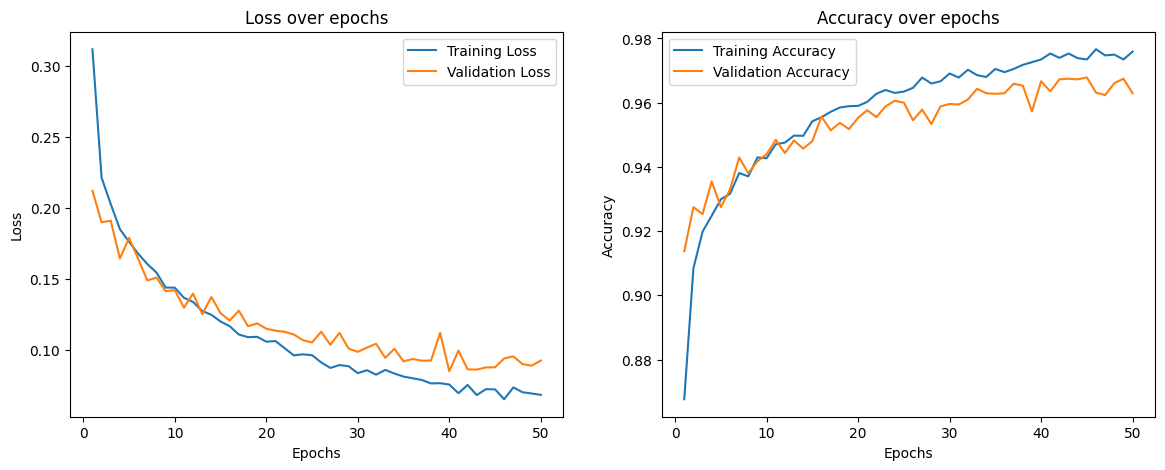

In [64]:
class MLP_opt3(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(MLP_opt3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_opt3 = MLP_opt3(input_size=X.shape[1])
model_opt3.to(device)
print(device)

epoch_num = 50
learning_rate = 0.001
weight_decay = 1e-3
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model_opt3, train_loader, valid_loader, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)



**Hyperparameter optimazing** on MLP_opt 3 due to its highest validation accuracy

Created grid search tool to test the below combinations
- Learning Rates Tested: [1.e-02 1.e-03 1.e-04 1.e-05]
- Dropout Rates Tested: [0.1 0.2 0.3]
- Number of Epochs Tested: [ 10  20  30  40  50  60  70 100]
- Weight Decays Tested: [1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08]

In [36]:
import itertools

# Define your hyperparameters to test
learning_rates = [0.1, 1e-2, 1e-3, 1e-4, 1e-5]
dropout_rates = [0.1, 0.2, 0.3]
epoch_num = [10, 20, 30, 40, 50, 60, 70, 100]
weight_decays = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]  # Adding weight_decay as a hyperparameter

hyperparameter_combinations = list(itertools.product(learning_rates, dropout_rates, epoch_num, weight_decays))

results_file = 'model_hyperparameter_search_results.csv'

# # Check if the file already exists
# if not os.path.isfile(results_file):
#     # Create a new DataFrame to store results
#     pd.DataFrame(columns=['learning_rate', 'dropout_rate', 'num_epochs', 'weight_decay', 'best_epoch',
#                           'final_train_loss', 'final_val_loss', 'final_train_accuracy', 'final_val_accuracy']).to_csv(results_file, index=False)

# # Iterate over all combinations
# for lr, dr, ne, wd in hyperparameter_combinations:
#     print(f"Training with learning rate: {lr}, dropout rate: {dr}, epoch_num: {ne}, weight_decay: {wd}")

#     # Create a new instance of the model with current dropout rate
#     model = MLP_opt3(input_size=X.shape[1], dropout_rate=dr)

#     # Define the loss function and optimizer with current learning rate and weight decay
#     # criterion = nn.BCELoss()
#     # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#     # Train the model (using your existing train_and_evaluate function)

#     train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
#     model, train_loader, valid_loader, num_epochs=ne, learning_rate=lr, weight_decay=wd)

#     # Save the results
#     result = {
#         'learning_rate': lr,
#         'dropout_rate': dr,
#         'num_epochs': ne,
#         'weight_decay': wd,
#         'best_epoch': best_epoch,
#         'final_train_loss': train_losses[-1],
#         'final_val_loss': val_losses[-1],
#         'final_train_accuracy': train_accuracies[-1],
#         'final_val_accuracy': val_accuracies[-1]
#     }

#     # Append result to the CSV file
#     pd.DataFrame([result]).to_csv(results_file, mode='a', header=False, index=False)



In [37]:
grid_search_results = pd.read_csv('model_hyperparameter_search_results.csv')

# Sort the results by validation accuracy
sorted_results = grid_search_results.sort_values(by='final_val_accuracy', ascending=False)

# Display the top result
top_result = sorted_results.iloc[0]
print("The combination with the highest validation accuracy is:")
print(top_result)

The combination with the highest validation accuracy is:
learning_rate            0.001000
dropout_rate             0.100000
num_epochs              50.000000
weight_decay             0.000001
best_epoch              35.000000
final_train_loss         0.020684
final_val_loss           0.130648
final_train_accuracy     0.993193
final_val_accuracy       0.970196
Name: 124, dtype: float64


Build the model with the most optimal parameters following the same structure as MLP_opt3

cuda:0
Epoch 1/50, Training Loss: 0.2997, Training Accuracy: 0.8742, Validation Loss: 0.2033, Validation Accuracy: 0.9161
Epoch 2/50, Training Loss: 0.2059, Training Accuracy: 0.9162, Validation Loss: 0.1788, Validation Accuracy: 0.9280
Epoch 3/50, Training Loss: 0.1769, Training Accuracy: 0.9298, Validation Loss: 0.1691, Validation Accuracy: 0.9310
Epoch 4/50, Training Loss: 0.1601, Training Accuracy: 0.9358, Validation Loss: 0.1669, Validation Accuracy: 0.9375
Epoch 5/50, Training Loss: 0.1456, Training Accuracy: 0.9429, Validation Loss: 0.1440, Validation Accuracy: 0.9424
Epoch 6/50, Training Loss: 0.1288, Training Accuracy: 0.9487, Validation Loss: 0.1361, Validation Accuracy: 0.9431
Epoch 7/50, Training Loss: 0.1200, Training Accuracy: 0.9535, Validation Loss: 0.1360, Validation Accuracy: 0.9455
Epoch 8/50, Training Loss: 0.1088, Training Accuracy: 0.9583, Validation Loss: 0.1229, Validation Accuracy: 0.9520
Epoch 9/50, Training Loss: 0.1009, Training Accuracy: 0.9608, Validation 

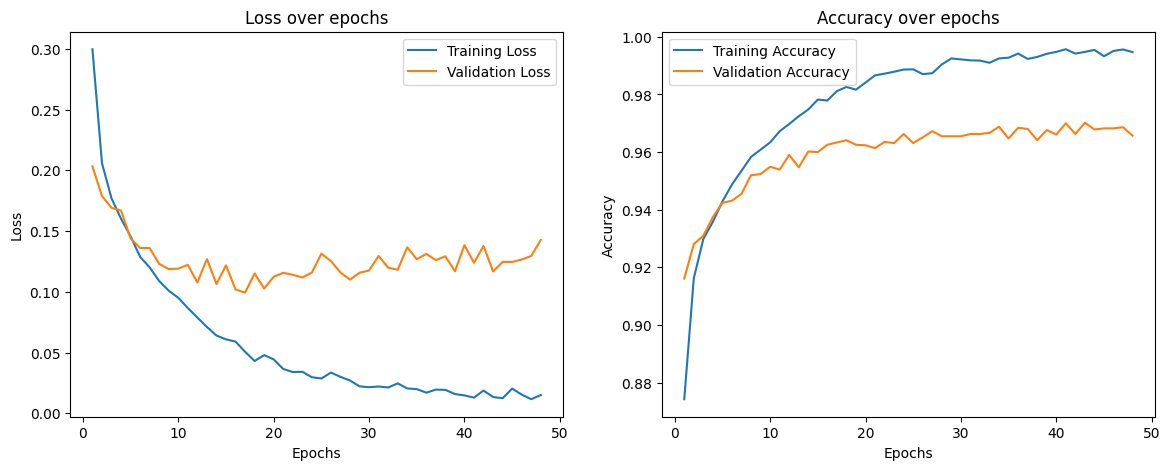

In [38]:
class MLP_opt4(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(MLP_opt4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_opt4 = MLP_opt4(input_size=X.shape[1], dropout_rate=0.1)
model_opt4.to(device)
print(device)

epoch_num = 50
learning_rate = 0.001
weight_decay = 1e-6
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model_opt4, train_loader, valid_loader, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [65]:
# # save best performing model
# torch.save(model_opt4.state_dict(), 'best_model.pth')


Due to the problem of high false negatives and low true positive indicated in confusion matrix, we decided to remove dropour layer. Therefore, we need to test the best parameters for the model without dropout layer (MLP_opt2)

Grid search tool combination
- Learning Rates Tested: [1.e-02 1.e-03 1.e-04 1.e-05]
- Number of Epochs Tested: [10  20  30  40  50  60]
- Weight Decays Tested: [1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08]

In [40]:
# Define your hyperparameters to test
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
# dropout_rates = [0]
epoch_num = [10, 20, 30, 40, 50, 60]
weight_decays = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]  # Adding weight_decay as a hyperparameter

hyperparameter_combinations = list(itertools.product(learning_rates, epoch_num, weight_decays))

results_file = 'no_drop_model_hyperparameter_search_results.csv'

# # Check if the file already exists
# if not os.path.isfile(results_file):
#     # Create a new DataFrame to store results
#     pd.DataFrame(columns=['learning_rate', 'num_epochs', 'weight_decay', 'best_epoch',
#                           'final_train_loss', 'final_val_loss', 'final_train_accuracy', 'final_val_accuracy']).to_csv(results_file, index=False)

# # Iterate over all combinations
# for lr, ne, wd in hyperparameter_combinations:
#     print(f"Training with learning rate: {lr}, epoch_num: {ne}, weight_decay: {wd}")

#     # Create a new instance of the model with current dropout rate
#     model = MLP_opt2(input_size=X.shape[1])

#     # Define the loss function and optimizer with current learning rate and weight decay
#     # criterion = nn.BCELoss()
#     # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#     # Train the model (using your existing train_and_evaluate function)

#     train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
#     model, train_loader, valid_loader, num_epochs=ne, learning_rate=lr, weight_decay=wd)

#     # Save the results
#     result = {
#         'learning_rate': lr,
#         'num_epochs': ne,
#         'weight_decay': wd,
#         'best_epoch': best_epoch,
#         'final_train_loss': train_losses[-1],
#         'final_val_loss': val_losses[-1],
#         'final_train_accuracy': train_accuracies[-1],
#         'final_val_accuracy': val_accuracies[-1]
#     }

#     # Append result to the CSV file
#     pd.DataFrame([result]).to_csv(results_file, mode='a', header=False, index=False)



In [41]:
grid_search_results = pd.read_csv('no_drop_model_hyperparameter_search_results.csv')

# Sort the results by validation accuracy
sorted_results = grid_search_results.sort_values(by='final_val_accuracy', ascending=False)

# Display the top result
top_result = sorted_results.iloc[0]
print("The combination with the highest validation accuracy is:")
print(top_result)

The combination with the highest validation accuracy is:
learning_rate           1.000000e-03
num_epochs              4.000000e+01
weight_decay            1.000000e-07
best_epoch              2.700000e+01
final_train_loss        1.015445e-04
final_val_loss          2.073954e-01
final_train_accuracy    1.000000e+00
final_val_accuracy      9.713725e-01
Name: 68, dtype: float64


Build model without dropout with the most optimal parameters following the structure of MLP_opt2

cuda:0
Epoch 1/40, Training Loss: 0.2862, Training Accuracy: 0.8794, Validation Loss: 0.2083, Validation Accuracy: 0.9108
Epoch 2/40, Training Loss: 0.1930, Training Accuracy: 0.9209, Validation Loss: 0.1846, Validation Accuracy: 0.9247
Epoch 3/40, Training Loss: 0.1629, Training Accuracy: 0.9327, Validation Loss: 0.1660, Validation Accuracy: 0.9300
Epoch 4/40, Training Loss: 0.1386, Training Accuracy: 0.9447, Validation Loss: 0.1459, Validation Accuracy: 0.9384
Epoch 5/40, Training Loss: 0.1231, Training Accuracy: 0.9508, Validation Loss: 0.1367, Validation Accuracy: 0.9475
Epoch 6/40, Training Loss: 0.1043, Training Accuracy: 0.9592, Validation Loss: 0.1352, Validation Accuracy: 0.9463
Epoch 7/40, Training Loss: 0.0902, Training Accuracy: 0.9672, Validation Loss: 0.1833, Validation Accuracy: 0.9284
Epoch 8/40, Training Loss: 0.0856, Training Accuracy: 0.9671, Validation Loss: 0.1408, Validation Accuracy: 0.9486
Epoch 9/40, Training Loss: 0.0741, Training Accuracy: 0.9721, Validation 

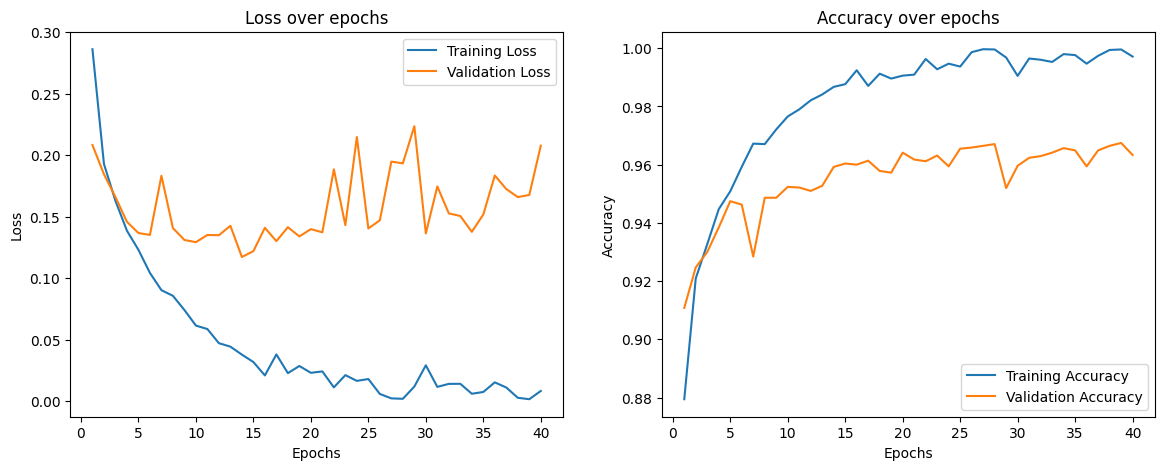

In [69]:
class MLP_opt_nodrop(nn.Module):
    def __init__(self, input_size):
        super(MLP_opt_nodrop, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_opt_nodrop = MLP_opt_nodrop(input_size=X.shape[1])
model_opt_nodrop.to(device)
print(device)

epoch_num = 40
learning_rate = 0.001
weight_decay = 1e-7
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model_opt_nodrop, train_loader, valid_loader, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)



In [43]:
# # save best performing model
# torch.save(model_opt_nodrop.state_dict(), 'best_model_nodrop.pth')

# **Results and Evulation**

Set the first benchmark by train and validate the best performing model with data before SMOTE

In [44]:
X_raw = df_encoded.drop('Attrition_Flag', axis=1).values  # Convert to numpy
y_raw = df_encoded['Attrition_Flag'].values

# Split the data into train and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

In [45]:
print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train_raw.shape)
print(y_test_raw.shape)

(7088, 18)
(3039, 18)
(7088,)
(3039,)


In [46]:
# Standardize the data
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

# Convert arrays to PyTorch tensors
X_train_raw = torch.tensor(X_train_raw, dtype=torch.float32)
X_test_raw = torch.tensor(X_test_raw, dtype=torch.float32)
y_train_raw = torch.tensor(y_train_raw, dtype=torch.float32)
y_test_raw = torch.tensor(y_test_raw, dtype=torch.float32)

# Create Tensor datasets and data loaders
train_data_raw = TensorDataset(X_train_raw, y_train_raw)
test_data_raw = TensorDataset(X_test_raw, y_test_raw)

train_loader_raw = DataLoader(dataset=train_data_raw, batch_size=64, shuffle=True)
valid_loader_raw = DataLoader(dataset=test_data_raw, batch_size=64, shuffle=False)

In [47]:
print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train_raw.shape)
print(y_test_raw.shape)

torch.Size([7088, 18])
torch.Size([3039, 18])
torch.Size([7088])
torch.Size([3039])


cuda:0
Epoch 1/50, Training Loss: 0.2854, Training Accuracy: 0.8905, Validation Loss: 0.2414, Validation Accuracy: 0.9000
Epoch 2/50, Training Loss: 0.1929, Training Accuracy: 0.9216, Validation Loss: 0.1866, Validation Accuracy: 0.9204
Epoch 3/50, Training Loss: 0.1727, Training Accuracy: 0.9324, Validation Loss: 0.1777, Validation Accuracy: 0.9240
Epoch 4/50, Training Loss: 0.1534, Training Accuracy: 0.9375, Validation Loss: 0.1742, Validation Accuracy: 0.9256
Epoch 5/50, Training Loss: 0.1436, Training Accuracy: 0.9426, Validation Loss: 0.1690, Validation Accuracy: 0.9316
Epoch 6/50, Training Loss: 0.1293, Training Accuracy: 0.9471, Validation Loss: 0.1850, Validation Accuracy: 0.9266
Epoch 7/50, Training Loss: 0.1203, Training Accuracy: 0.9502, Validation Loss: 0.1754, Validation Accuracy: 0.9339
Epoch 8/50, Training Loss: 0.1142, Training Accuracy: 0.9540, Validation Loss: 0.1586, Validation Accuracy: 0.9332
Epoch 9/50, Training Loss: 0.1020, Training Accuracy: 0.9587, Validation 

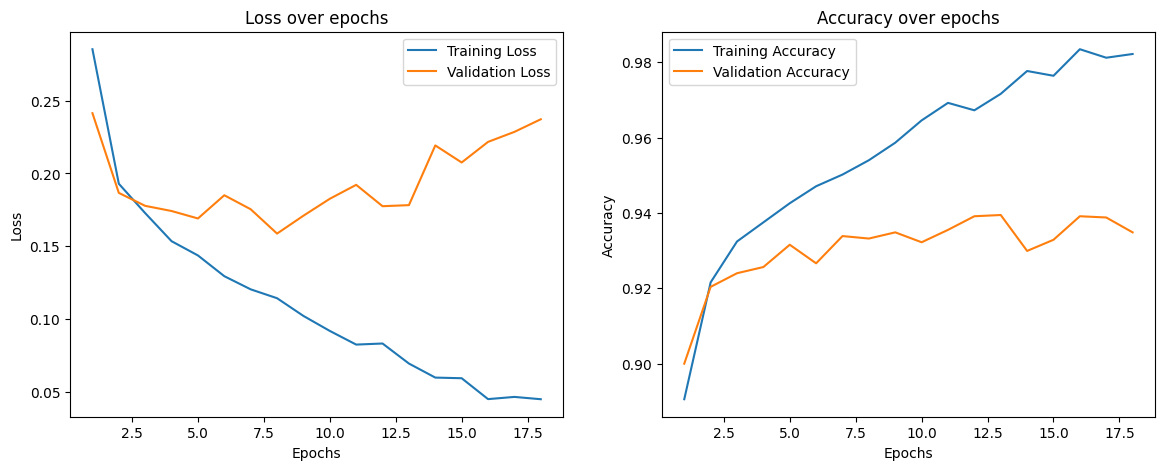

In [48]:
# define a model with the same parameters as the best_performing model
class MLP_opt_raw(nn.Module):
    def __init__(self, input_size):
        super(MLP_opt_raw, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_opt_raw = MLP_opt_raw(input_size=X_raw.shape[1])
model_opt_raw.to(device)
print(device)


epoch_num = 50
learning_rate = 0.001
weight_decay = 1e-6
train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_and_evaluate(
    model_opt_raw, train_loader_raw, valid_loader_raw, num_epochs=epoch_num, learning_rate=learning_rate, weight_decay=weight_decay)
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)



Set the second benchmark with a logistic regression. Using its f1, roc, confusion matrixs for comparision

In [49]:
# Create and train the logistic regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8686274509803922

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      2552
         1.0       0.88      0.86      0.87      2548

    accuracy                           0.87      5100
   macro avg       0.87      0.87      0.87      5100
weighted avg       0.87      0.87      0.87      5100



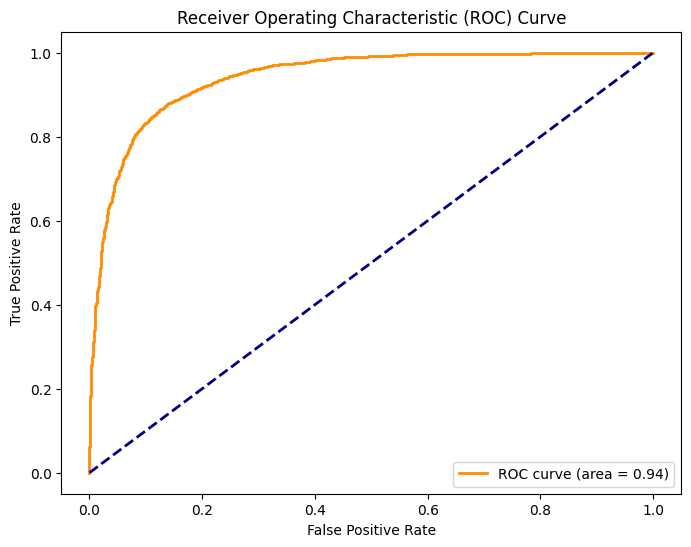

In [50]:
# Generate ROC curve values
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

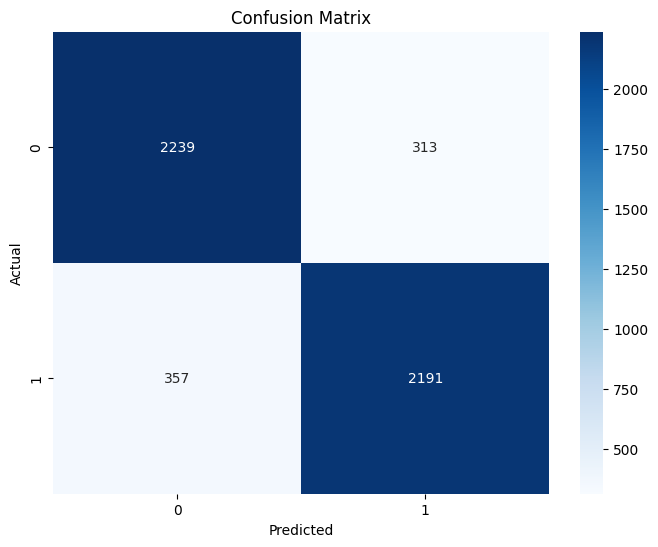

In [51]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Evulate the performance of best performing model with dropout to the logsitic regression benchmark

In [71]:
# F1 score
import torch
from sklearn.metrics import f1_score

# Load the best model
model = MLP_opt4(input_size=X.shape[1], dropout_rate=0.1)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Send model to device (cpu or cuda)
model.eval()  # Set the model to evaluation mode

# Assuming valid_loader is your DataLoader for the validation set
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        predictions = (outputs.squeeze() > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_true_labels, all_predictions, average='binary')
print(f"F1 Score: {f1}")


F1 Score: 0.7186796699174792


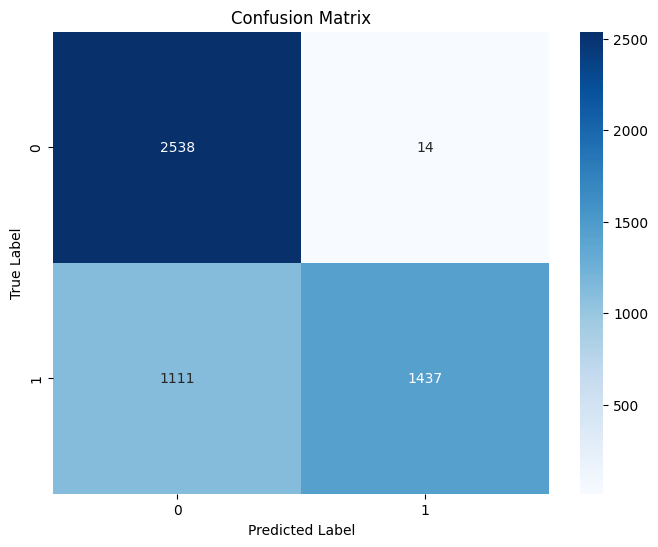

In [72]:
# Load your model and set it to evaluation mode
model = MLP_opt4(input_size=X.shape[1], dropout_rate=0.1)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Send model to device (cpu or cuda)
model.eval()  # Set the model to evaluation mode

# Collect predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = (outputs.squeeze() > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


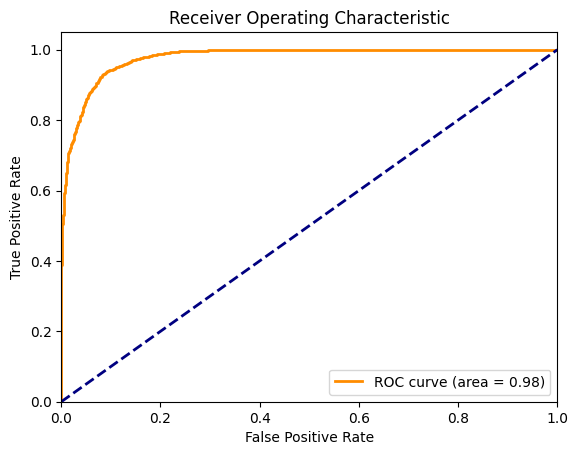

In [73]:
# Load the best model
model = MLP_opt4(input_size=X.shape[1], dropout_rate=0.1)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Get model predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = outputs.squeeze()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Based on the F1 score and confusion matrix, we found a much higher number of false negatives and less true positives in the model than benchmark, meaning the model is not capturing the positive class well. Since we have tested mutiple dropout rate previously, we think it might be a problem due to dropout layer.

As a result, we choose to remove the dropout layer and find optimal hyparameters for the new best model. By calling `best_model_nodrop.pth`, we can evulate this model and compare with the benchmark

In [74]:
# F1 score for best model without dropout
import torch
from sklearn.metrics import f1_score

# Load the best model
model = MLP_opt2(input_size=X.shape[1])
model.load_state_dict(torch.load('best_model_nodrop.pth'))
model.to(device)  # Send model to device (cpu or cuda)
model.eval()  # Set the model to evaluation mode

# Assuming valid_loader is your DataLoader for the validation set
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        predictions = (outputs.squeeze() > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_true_labels, all_predictions, average='binary')
print(f"F1 Score: {f1}")


F1 Score: 0.9705135715680531


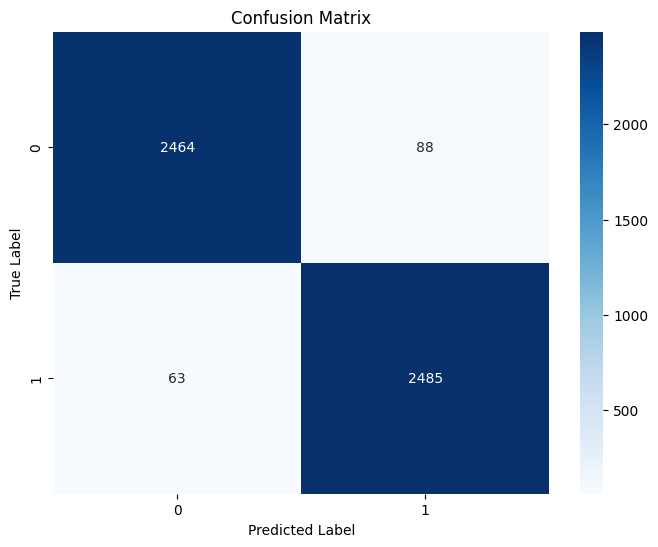

In [75]:
# Confusion matrix for best model without dropout
# Load your model and set it to evaluation mode
model = MLP_opt2(input_size=X.shape[1])
model.load_state_dict(torch.load('best_model_nodrop.pth'))
model.to(device)  # Send model to device (cpu or cuda)
model.eval()  # Set the model to evaluation mode

# Collect predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = (outputs.squeeze() > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


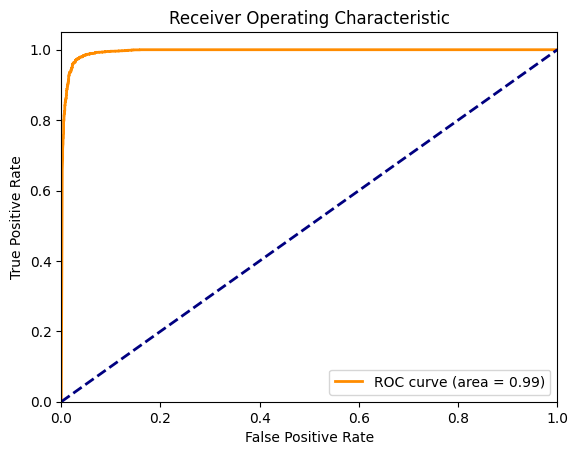

In [76]:
# Load the best model
model = MLP_opt2(input_size=X.shape[1])
model.load_state_dict(torch.load('best_model_nodrop.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Get model predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = outputs.squeeze()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
